# Conversational Chess using non-OpenAI clients

This notebook provides tips for using non-OpenAI models when using functions/tools.

The code is based on [this notebook](/docs/notebooks/agentchat_nested_chats_chess),
which provides a detailed look at nested chats for tool use. Please refer to that
notebook for more on nested chats as this will be concentrated on tweaks to
improve performance with non-OpenAI models.

The notebook represents a chess game between two players with a nested chat to
determine the available moves and select a move to make.

This game contains a couple of functions/tools that the LLMs must use correctly by the
LLMs:
- `get_legal_moves` to get a list of current legal moves.
- `make_move` to make a move.

Two agents will be used to represent the white and black players, each associated with
a different LLM cloud provider and model:
- Anthropic's Sonnet 3.5 will be Player_White
- Mistral's Mixtral 8x7B (using Together.AI) will be Player_Black

As this involves function calling, we use larger, more capable, models from these providers.

The nested chat will be supported be a board proxy agent who is set up to execute
the tools and manage the game.

Tips to improve performance with these non-OpenAI models will be noted throughout **in bold**.

## Installation

First, you need to install the `pyautogen` and `chess` packages to use AutoGen. We'll include Anthropic and Together.AI libraries.

In [1]:
! pip install -qqq pyautogen[anthropic,together] chess

## Setting up LLMs

We'll use the Anthropic (`api_type` is `anthropic`) and Together.AI (`api_type` is `together`) client classes, with their respective models, which both support function calling.

In [5]:
import os

import chess
import chess.svg
from IPython.display import display
from typing_extensions import Annotated

from autogen import ConversableAgent, register_function

# Let's set our two player configs, specifying clients and models

# Anthropic's Sonnet for player white
player_white_config_list = [
    {
        "api_type": "anthropic",
        "model": "claude-3-5-sonnet-20240620",
        "api_key": os.getenv("ANTHROPIC_API_KEY"),
        "cache_seed": None,
    },
]

# Mistral's Mixtral 8x7B for player black (through Together.AI)
player_black_config_list = [
    {
        "api_type": "together",
        "model": "mistralai/Mixtral-8x7B-Instruct-v0.1",
        "api_key": os.environ.get("TOGETHER_API_KEY"),
        "cache_seed": None,
    },
]

We'll setup game variables and the two functions for getting the available moves and then making a move.

In [3]:
# Initialize the board.
board = chess.Board()

# Keep track of whether a move has been made.
made_move = False


def get_legal_moves() -> Annotated[
    str,
    "Call this tool to list of all legal chess moves on the board, output is a list in UCI format, e.g. e2e4,e7e5,e7e8q.",
]:
    return "Possible moves are: " + ",".join([str(move) for move in board.legal_moves])


def make_move(
    move: Annotated[
        str,
        "Call this tool to make a move after you have the list of legal moves and want to make a move. Takes UCI format, e.g. e2e4 or e7e5 or e7e8q.",
    ]
) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    # Display the board.
    display(
        chess.svg.board(board, arrows=[(move.from_square, move.to_square)], fill={move.from_square: "gray"}, size=200)
    )
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from {chess.SQUARE_NAMES[move.from_square]} to {chess.SQUARE_NAMES[move.to_square]}."

## Creating agents

Our main player agents are created next, with a few tweaks to help our models play:

- Explicitly **telling agents their names** (as the name field isn't sent to the LLM).
- Providing simple instructions on the **order of functions** (not all models will need it).
- Asking the LLM to **include their name in the response** so the message content will include their names, helping the LLM understand who has made which moves.
- Ensure **no spaces are in the agent names** so that their name is distinguishable in the conversation.


In [6]:
player_white = ConversableAgent(
    name="Player_White",
    system_message="You are a chess player and you play as white, your name is 'Player_White'. "
    "First call the function get_legal_moves() to get list of legal moves. "
    "Then call the function make_move(move) to make a move. "
    "Then tell Player_Black you have made your move and it is their turn. "
    "Make sure you tell Player_Black you are Player_White.",
    llm_config={"config_list": player_white_config_list, "cache_seed": None},
)

player_black = ConversableAgent(
    name="Player_Black",
    system_message="You are a chess player and you play as black, your name is 'Player_Black'. "
    "First call the function get_legal_moves() to get list of legal moves. "
    "Then call the function make_move(move) to make a move. "
    "Then tell Player_White you have made your move and it is their turn. "
    "Make sure you tell Player_White you are Player_Black.",
    llm_config={"config_list": player_black_config_list, "cache_seed": None},
)

Now we create a proxy agent that will be used to move the pieces on the board.

In [7]:
# Check if the player has made a move, and reset the flag if move is made.
def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


board_proxy = ConversableAgent(
    name="Board_Proxy",
    llm_config=False,
    # The board proxy will only terminate the conversation if the player has made a move.
    is_termination_msg=check_made_move,
    # The auto reply message is set to keep the player agent retrying until a move is made.
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

Our functions are then assigned to the agents so they can be passed to the LLM to choose from.

We have tweaked the descriptions to provide **more guidance on when** to use it.

In [ ]:
register_function(
    make_move,
    caller=player_white,
    executor=board_proxy,
    name="make_move",
    description="Call this tool to make a move after you have the list of legal moves.",
)

register_function(
    get_legal_moves,
    caller=player_white,
    executor=board_proxy,
    name="get_legal_moves",
    description="Call this to get a legal moves before making a move.",
)

register_function(
    make_move,
    caller=player_black,
    executor=board_proxy,
    name="make_move",
    description="Call this tool to make a move after you have the list of legal moves.",
)

register_function(
    get_legal_moves,
    caller=player_black,
    executor=board_proxy,
    name="get_legal_moves",
    description="Call this to get a legal moves before making a move.",
)

Almost there, we now create nested chats between players and the board proxy agent to work out the available moves and make the move.

In [9]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            # The initial message is the one received by the player agent from
            # the other player agent.
            "sender": board_proxy,
            "recipient": player_white,
            # The final message is sent to the player agent.
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            # The initial message is the one received by the player agent from
            # the other player agent.
            "sender": board_proxy,
            "recipient": player_black,
            # The final message is sent to the player agent.
            "summary_method": "last_msg",
        }
    ],
)

## Playing the game

Now the game can begin!

Player_Black (to Player_White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board_Proxy (to Player_White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

Certainly! I'd be happy to play chess with you. As White, I'll make the first move. Let me start by checking the legal moves available to me.
***** Suggested tool call (toolu_015sLMucefMVqS5ZNyWVGjgu): get_legal_moves *****
Arguments: 
{}
*********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION g

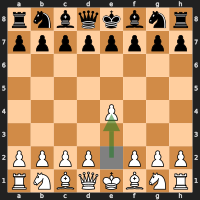

Board_Proxy (to Player_White):

Board_Proxy (to Player_White):

***** Response from calling tool (toolu_01VjmBhHcGw5RTRKYC4Y5MeV) *****
Moved pawn (♙) from e2 to e4.
***********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_White (to Board_Proxy):

Hello, Player_Black! I'm Player_White, and I've just made my move. I've chosen to play the classic opening move e2e4, moving my king's pawn forward two squares. This opens up lines for both my queen and king's bishop, and stakes a claim to the center of the board. It's now your turn to make a move. Good luck!

--------------------------------------------------------------------------------
Player_White (to Player_Black):

Hello, Player_Black! I'm Player_White, and I've just made my move. I've chosen to play the classic opening move e2e4, moving my king's pawn forward two squares. This opens up lines for both my

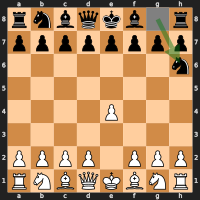

Board_Proxy (to Player_Black):

Board_Proxy (to Player_Black):

***** Response from calling tool (call_59t20pl0ab68z4xx2workgbc) *****
Moved knight (♞) from g8 to h6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player_Black (to Board_Proxy):

***** Suggested tool call (call_jwv1d86srs1fnvu33cky9tgv): make_move *****
Arguments: 
{"move":"g8h6"}
**************************************************************************

--------------------------------------------------------------------------------
Player_Black (to Player_White):



--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...


In [10]:
# Clear the board.
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=10,
)

At this stage, it's hard to tell who's going to win, but they're playing well and using the functions correctly.